In [1]:
from scipy.spatial.distance import euclidean, mahalanobis
import torch
import os
from pathlib import Path
from utils.preprocessing import load_txt_data
from utils.probe_confidence_intervals import model_setup
from utils.create_steering_vectors import compute_all_steering_vectors
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np

In [2]:
def load_targeted_steering_vectors(steering_vector_path: str) -> tuple[dict,dict,dict]:
    """loads steering vectors that are targeted towards a language. 
    it returns the target, complement and combined, with combined = target - complement

    Args:
        steering_vector_path (str): some path

    Returns:
        tuple[dict,dict,dict]: target, complement, combined
    """
    combined = dict()
    complement = dict()
    target = dict()
    for vector in os.listdir(steering_vector_path):
        type = vector.split("_")[0]
        layer = vector.split("_")[4]
        if type == "combined":
            combined[int(layer)] = torch.load(str(steering_vector_path +vector))
        elif type == "complement":
            complement[int(layer)] = torch.load(str(steering_vector_path + vector))
        elif type == "target":
            target[int(layer)] = torch.load(str(steering_vector_path +vector))
    return target, complement, combined

steering_vector_path = "steering_vectors/test_run_2/"

target, complement, combined = load_targeted_steering_vectors(steering_vector_path)

li = []
for layer in sorted(target.keys()):
    target_vector = target[layer]
    complement_vector = complement[layer]
    dist = euclidean(target_vector,complement_vector)
    li.append(dist)



/var/folders/p0/267bnxr16cq2xpr1crtpxbgw0000gn/T/ipykernel_4215/3286106827.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  complement[int(layer)] = torch.load(str(steer

In [4]:
def create_average_activations(languages:list[str],model_name:str,run_name:str):

    model, tokenizer, device = model_setup(model_name)

    raw_data_folder = Path('data/antibiotic/')
    print("Load data")

    file_paths = {lang: raw_data_folder / f'{lang}.txt' for lang in languages }

    ds = load_txt_data(
        file_paths= file_paths,
        file_extension='txt'
    )

    meta_data = {}
    meta_data["hidden_layers"] = model.config.num_hidden_layers

    try:
        meta_data["hidden_size"] = model.config.n_embd
    except AttributeError:
        meta_data["hidden_size"] = model.config.hidden_size


    all_steering_vectos = compute_all_steering_vectors(ds,languages,meta_data, tokenizer, device, model)
    

    if not os.path.exists(f"average_activation_vectors/{run_name}"):
        os.makedirs(f"average_activation_vectors/{run_name}")

    for language, list_of_tensors in all_steering_vectos.items():
        for layer, tensor in enumerate(list_of_tensors):
            torch.save(tensor, f"average_activation_vectors/{run_name}/language_{language}_layer_{layer}_tensor.pt")

model_name = "AI-Sweden-Models/gpt-sw3-356m"
run_name = model_name.split("/")[1].replace("-","_")
languages = ["da","en","sv","nb","is"]
#create_average_activations(languages, model_name, run_name)
    

In [5]:

model, tokenizer, device = model_setup(model_name)

raw_data_folder = Path('data/antibiotic/')
print("Load data")

file_paths = {lang: raw_data_folder / f'{lang}.txt' for lang in languages }

ds = load_txt_data(
    file_paths= file_paths,
    file_extension='txt'
)

meta_data = {}
meta_data["hidden_layers"] = model.config.num_hidden_layers

try:
    meta_data["hidden_size"] = model.config.n_embd
except AttributeError:
    meta_data["hidden_size"] = model.config.hidden_size


all_steering_vectos = compute_all_steering_vectors(ds,languages,meta_data, tokenizer, device, model)

found device: cpu
Load data


 23%|██▎       | 6/26 [01:06<03:40, 11.04s/it]


In [1]:
from utils.distance_plots import plot_distances, compute_distance_metric, load_all_steering_vectors
temp = load_all_steering_vectors("average_activation_vectors/gpt_sw3_356m/")

/Users/marki/Documents/GitHub/KDS_MI/utils/distance_plots.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  steering_vector = torch.load(str(path + file))


In [2]:
target_language = "da"
distance_metric = "euclidean"
distance_dict = compute_distance_metric(temp, target_language, distance_metric)


In [14]:
len(all_steering_vectos["en"])

24

In [5]:
euclidean_dict = defaultdict(list)
for language in all_steering_vectos.keys():
    if language == "da":
        continue
    for lang_vector, da_vector in zip(all_steering_vectos[language],all_steering_vectos["da"]):
        dist = euclidean(lang_vector, da_vector)
        euclidean_dict[language].append(dist)

mahalanobis_dict = defaultdict(list)
for language in all_steering_vectos.keys():
    if language == "da":
        continue
    for lang_vector, da_vector in zip(all_steering_vectos[language],all_steering_vectos["da"]):
        V = np.cov(np.array([lang_vector, da_vector]).T)
        #Maybe we need to find a better covariance matrix. Maybe it needs to be for all vectors???
        IV = np.linalg.pinv(V) #pseudoinverse due to the matrix V being singular
        dist = mahalanobis(lang_vector, da_vector,IV)
        mahalanobis_dict[language].append(dist)

In [11]:
mahalanobis_dict

defaultdict(list,
            {'en': [1.412465737676669,
              1.4174813732702147,
              1.4116553045794942,
              1.4124970916612214,
              1.39069188850055,
              1.4035074706951172,
              1.4180664774783902,
              1.4218554526610565,
              1.4165764302197876,
              1.4221502092450877,
              1.4127439474076096,
              1.4154240997786236,
              1.4081662500747758,
              1.4165360599969585,
              1.4136832028719106,
              1.426430300198648,
              1.4021625801280297,
              1.4125268294973272,
              1.4166966409883124,
              1.3991667210467922,
              1.4120458416172623,
              1.4100515220298184,
              1.4506920742965401,
              1.424351976353939],
             'sv': [1.4232272723586283,
              1.4132866209989519,
              1.4146685315139604,
              1.409189055151487,
              1.4062806

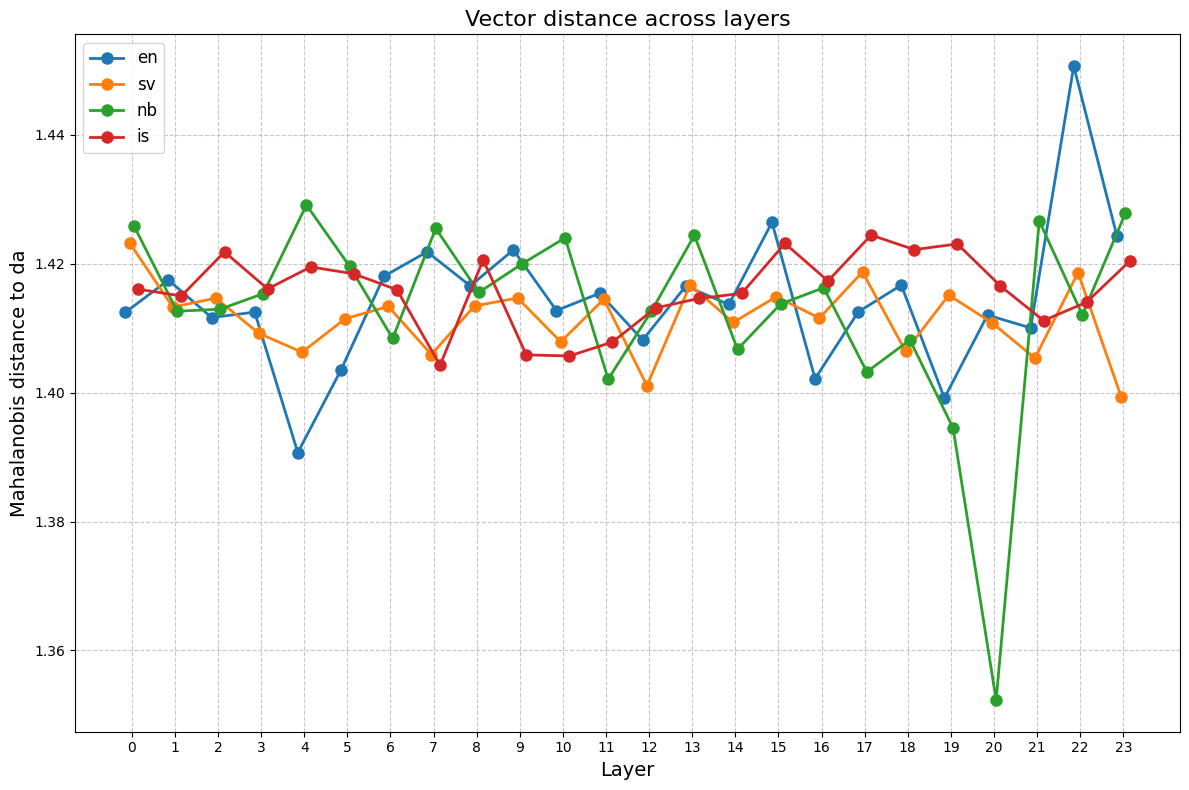

In [9]:
plot_distances(mahalanobis_dict,"da","mahalanobis")

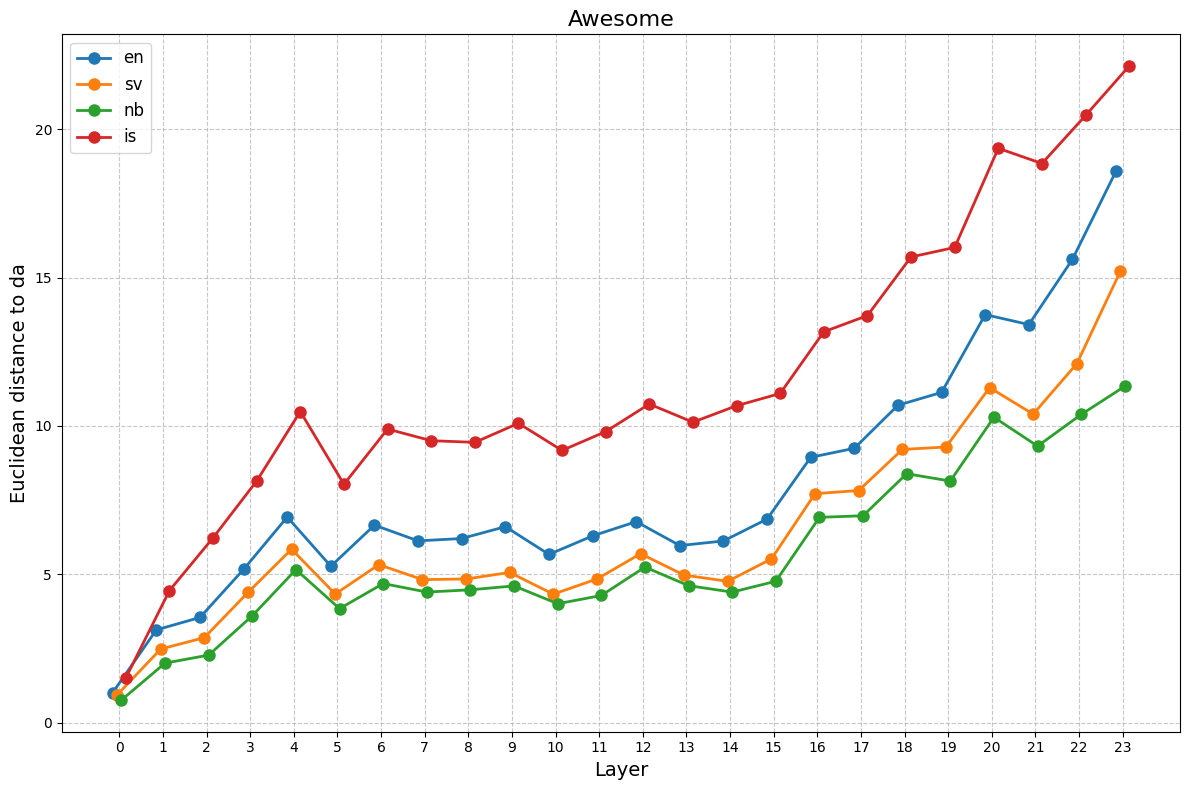

In [ ]:
plot_distances(mahalanobis_dict,"da","mahalanobis")